<a href="https://colab.research.google.com/github/RamenSlayer/StableDiffusionNotebooks/blob/master/stable_diffusion_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text2Image and Image2Image Pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [1]:
!nvidia-smi

Thu Jan  5 09:41:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Install dependencies

!pip install diffusers transformers ftfy accelerate
!pip install -qq "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.1 MB/s eta 0:00:00


For some models you need to accept the model license before downloading or using the weights. By default we're using `v1-5`, so you'll need to  visit [its card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. 

Other models I suggest are:

[hakurei/waifu-diffusion](https://huggingface.co/hakurei/waifu-diffusion)

[CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)

[Linaqruf/anything-v3.0](https://huggingface.co/Linaqruf/anything-v3.0)

[hakurei/artstation-diffusion](https://huggingface.co/hakurei/artstation-diffusion)

[nitrosocke/archer-diffusion](https://huggingface.co/nitrosocke/archer-diffusion)

[TryStar/CloneDiffusion](https://huggingface.co/TryStar/CloneDiffusion)

Visit the page and read it before using to understand more about it.

To accept, you need to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [ ]:
#@title Log into huggingface using the token
#@markdown Unneeded for some models.

from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Pipeline.

In [2]:
#@markdown Import libraries
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

Load the pipeline

In [3]:
device = "cuda"
#@markdown Pick img2img for img2img, else leave as is
pipeline_type = "StableDiffusionImg2ImgPipeline" #@param ["StableDiffusionPipeline", "StableDiffusionImg2ImgPipeline"]
if pipeline_type == "StableDiffusionPipeline":
  from diffusers import StableDiffusionPipeline as Pipeline
elif pipeline_type == "StableDiffusionImg2ImgPipeline":
  from diffusers import StableDiffusionImg2ImgPipeline as Pipeline

#@markdown Choose model
model_path = "Linaqruf/anything-v3.0" #@param ["hakurei/artstation-diffusion", "nitrosocke/archer-diffusion", "TryStar/CloneDiffusion", "runwayml/stable-diffusion-v1-5", "hakurei/waifu-diffusion", "CompVis/stable-diffusion-v1-4", "Linaqruf/anything-v3.0", "custom"]
#@markdown Touch only if you want to use a model that's not in the list
custom_model = "" #@param {type: 'string'}
use_token = False #@param {type: 'boolean'}
#@markdown Don't touch if you're not sure what it does
revision=None #@param {type: 'string'}
if model_path != "custom":
    if model_path.lower() == "CompVis/stable-diffusion-v1-4".lower():
        if revision is None:
            revision = "fp16"
        use_token = True
else:
    model_path = custom_model

pipe = Pipeline.from_pretrained(
    model_path,
    revision=revision,
    torch_dtype=torch.float16,
    use_auth_token=use_token
)
pipe = pipe.to(device)

#@markdown If you don't want the image to blackout when it detects NSFW. 
#@markdown Doesn't work for v2
enable_nsfw = True #@param {type: 'boolean'}

def dummy_checker(images, **kwargs):
  return images, False

if enable_nsfw:
    pipe.safety_checker = dummy_checker

Downloading:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/552 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [4]:
#@title Upload image for img2img. { display-mode: "form" }
#@markdown Upload an initial image to preprocess it 
#@markdown before passing to pipeline
from google.colab import files
uploaded = files.upload()
uploaded = list(uploaded.keys())

Saving lol.png to lol.png


In [5]:
#@markdown Print directory and see all uploaded files
!ls -F

lol.png  sample_data/


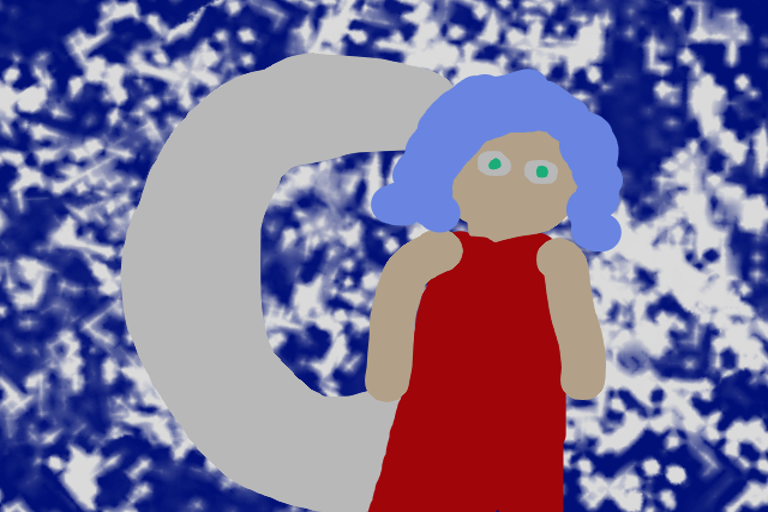

In [6]:
from PIL import Image

#@markdown Write the name of the file
img_path = "lol.png" #@param {type: 'string'}

init_img = Image.open(img_path).convert("RGB")

#@markdown Sides should be multiples of 64

x_resolution = 768 #@param {type: 'integer'}
y_resolution = 512 #@param {type: 'integer'}
init_img = init_img.resize((x_resolution, y_resolution))
init_img

In [9]:
#@markdown Define the prompt
prompt = "1girl standing in front of the moon, green eyes, dark night sky, stars" #@param {type: 'string'}
#@markdown Pick seed, guidance and steps for your generation
seed = 1024 #@param {type: 'integer'}
guidance_scale = 7.5 #@param {type: 'slider', min: 0, max: 50, step:0.25}
steps = 35 #@param {type: 'slider', min: 1, max: 75, step:1}
#@markdown Only for img2img. Defines the amount of noise added to input image
strength = 0.75 #@param {type: 'slider', min: 0, max: 1, step:0.025}
#@markdown Only for txt2img. Defines output resolution. Keep at multiples of 64.
height = 512 #@param {type: 'integer'}
width = 512 #@param {type: 'integer'}

generator = torch.Generator(device=device).manual_seed(seed)
with autocast("cuda"):
    if pipeline_type == "StableDiffusionImg2ImgPipeline":
        image = pipe(prompt=prompt,
                    image=init_img, # change image to init_image if recieving error
                    strength=strength,
                    guidance_scale=guidance_scale, 
                    num_inference_steps = steps,
                    generator=generator,
                    ).images[0]
    elif pipeline_type == "StableDiffusionPipeline":
        image = pipe(prompt=prompt,
                     guidance_scale=guidance_scale,
                     num_inference_steps = steps, 
                     generator=generator, 
                     height=height, 
                     width=width,
                     ).images[0]


  0%|          | 0/26 [00:00<?, ?it/s]

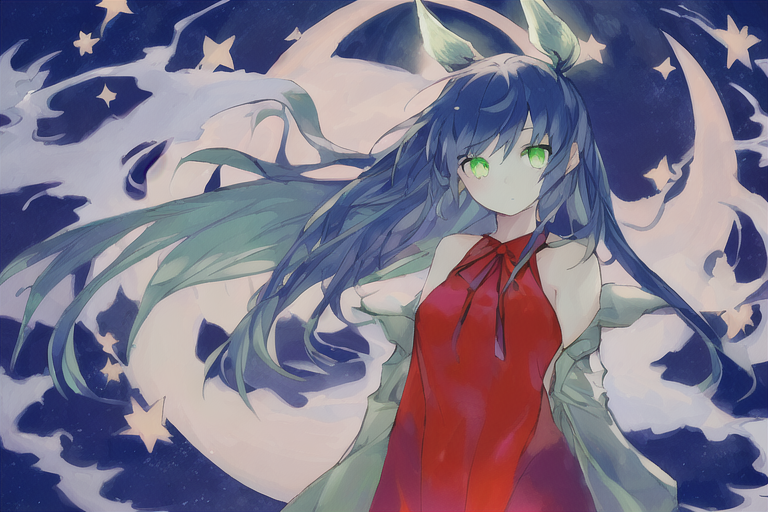

In [10]:
image

As you can see, when using a lower value for `strength`, the generated image is more closer to the original `init_image`


Now using [LMSDiscreteScheduler](https://huggingface.co/docs/diffusers/api/schedulers#diffusers.LMSDiscreteScheduler)

In [ ]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
pipe.scheduler = lms

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

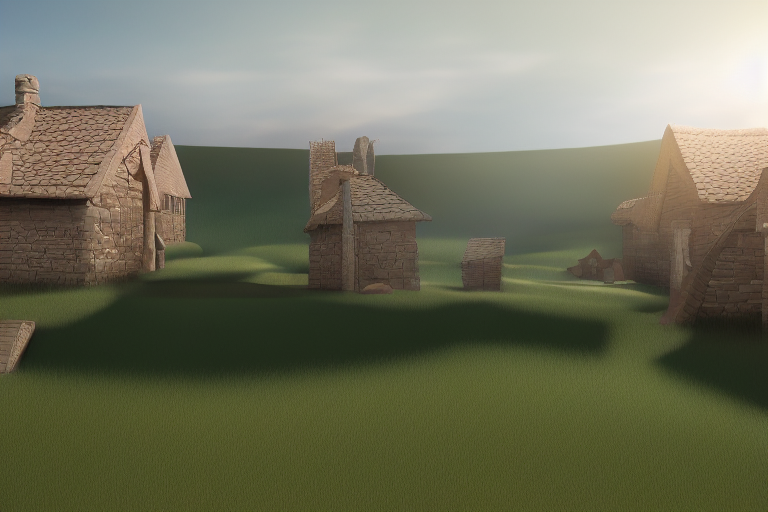

In [ ]:
image